In [1]:
from catboost import CatBoostRegressor
from catboost import cv, Pool
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


сначало сделаем что написал в выводе анализа

In [2]:
df = pd.read_csv('df_result_1.csv')
df = df[df['ZOI_drug_NP'] > 0]

In [3]:
print(df[df['ZOI_drug']>= 60].shape)
df = df[df['ZOI_drug'] < 60]

(21, 16)


разбиение на тренировочную и валидацию (тест у организаторов)

In [4]:
train, test = train_test_split(df,random_state=42)

In [5]:
df.columns

Index(['Unnamed: 0', 'NP size_min', 'NP size_max', 'NP size_avg', 'ZOI_drug',
       'ZOI_drug_NP', 'NumHDonors', 'NumHAcceptors', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge', 'MinPartialCharge', 'avg_Incub_period, h',
       'growth_temp, C', 'biosafety_level', 'shape_nanorods_and_triangles',
       'gram_p'],
      dtype='object')

In [6]:
df.drop('Unnamed: 0',axis = 1)

,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",biosafety_level,shape_nanorods_and_triangles,gram_p
0,4.0,10.0,8.0,17.0000,32.000,4.0,6.0,0.507967,0.327399,-0.507967,84.0,37.0,2.0,0.0,0
1,4.0,10.0,8.0,17.0000,32.000,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,2.0,0.0,0
2,15.0,30.0,28.0,17.0000,32.000,4.0,6.0,0.507967,0.327399,-0.507967,84.0,37.0,2.0,0.0,0
3,15.0,30.0,28.0,17.0000,32.000,1.0,5.0,1.000000,0.547832,-0.547832,84.0,37.0,2.0,0.0,0
4,5.0,30.0,21.0,0.0000,17.000,19.0,25.0,0.507810,0.330441,-0.507810,288.0,30.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,4.0,10.0,8.0,0.2500,0.125,4.0,6.0,0.507967,0.327399,-0.507967,36.0,37.0,2.0,0.0,0
530,4.0,10.0,8.0,1.0000,0.125,4.0,6.0,0.507967,0.327399,-0.507967,36.0,37.0,2.0,0.0,1
531,5.0,80.0,60.0,0.3125,0.100,4.0,6.0,0.507967,0.327399,-0.507967,18.0,37.0,2.0,0.0,0
532,4.0,10.0,8.0,0.0300,0.030,8.0,12.0,0.387562,0.185232,-0.387562,36.0,37.0,2.0,0.0,1


In [7]:
X = ['NP size_min', 'NP size_max', 'NP size_avg', 'ZOI_drug', 'NumHDonors',
     'NumHAcceptors', 'MaxAbsPartialCharge','MinAbsPartialCharge', 'MinPartialCharge', 'avg_Incub_period, h','growth_temp, C', 'shape_nanorods_and_triangles','gram_p','biosafety_level']
y = ['ZOI_drug_NP']

In [8]:
train_data = Pool(data=train[X],
                  label=train[y],
                 )

In [9]:
test_data = Pool(data=test[X],
                  label=test[y],
                 )

In [10]:
params = {'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
              'learning_rate': 0.02,
              'random_seed': 2007,
              'verbose':100}

In [11]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200
)

Training on fold [0/5]

bestTest = 6.433766795
bestIteration = 584

Training on fold [1/5]

bestTest = 4.543113933
bestIteration = 497

Training on fold [2/5]

bestTest = 3.397367064
bestIteration = 756

Training on fold [3/5]

bestTest = 3.61380144
bestIteration = 626

Training on fold [4/5]

bestTest = 4.999743907
bestIteration = 928



In [12]:
cv_data.head()

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,19.090903,1.114799,19.095967,0.281669
1,1,18.831736,1.112275,18.827799,0.281196
2,2,18.551565,1.108386,18.544882,0.280568
3,3,18.281415,1.098740,18.268833,0.278522
4,4,18.019224,1.105090,17.997109,0.273767


In [13]:
cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].min()]

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
774,774,4.621772,1.222653,2.062056,0.200451


In [14]:
n_iters = cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].min()]['iterations'].values[0]
n_iters

774

In [15]:
params = {'eval_metric': 'RMSE',
          'loss_function': 'RMSE',
              'learning_rate': 0.02,
              'random_seed': 2007,
              'verbose':100}

In [16]:
model = CatBoostRegressor(**params)

In [17]:
train_data.shape

(384, 14)

In [18]:
model.fit(train_data)

0:	learn: 9.3261653	total: 753us	remaining: 753ms
100:	learn: 4.7709206	total: 48.9ms	remaining: 435ms
200:	learn: 3.7753693	total: 102ms	remaining: 405ms
300:	learn: 3.3399940	total: 150ms	remaining: 348ms
400:	learn: 3.0424324	total: 200ms	remaining: 298ms
500:	learn: 2.8545044	total: 265ms	remaining: 264ms
600:	learn: 2.7001842	total: 313ms	remaining: 208ms
700:	learn: 2.5162813	total: 360ms	remaining: 154ms
800:	learn: 2.3501897	total: 410ms	remaining: 102ms
900:	learn: 2.1677795	total: 459ms	remaining: 50.5ms
999:	learn: 2.0357450	total: 507ms	remaining: 0us


In [19]:
test['y_pred'] = model.predict(test_data)

In [20]:
test['y_pred'] = model.predict(test_data)

In [21]:
test

,Unnamed: 0,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,"avg_Incub_period, h","growth_temp, C",biosafety_level,shape_nanorods_and_triangles,gram_p,y_pred
318,341,8.0,20.0,13.5,15.000,15.00,1.0,5.0,1.000000,0.547832,-0.547832,36.00,37.0,2.0,1.0,1,14.774641
517,565,5.0,80.0,60.0,0.625,0.30,2.0,12.0,0.476561,0.352158,-0.476561,48.00,37.0,2.0,0.0,0,1.456666
453,500,8.0,20.0,13.5,8.000,8.00,5.0,14.0,0.458937,0.311188,-0.458937,36.00,37.0,2.0,1.0,0,11.173148
161,177,5.0,30.0,21.0,19.000,21.00,3.0,5.0,0.479673,0.327399,-0.479673,288.00,30.0,1.0,0.0,1,22.405574
519,567,5.0,80.0,60.0,0.625,0.30,4.0,6.0,0.507967,0.327399,-0.507967,36.00,37.0,2.0,0.0,1,1.041055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,451,8.0,20.0,13.5,7.000,10.00,11.0,15.0,0.393567,0.186623,-0.393567,60.00,30.0,2.0,1.0,0,12.934972
20,20,8.0,20.0,13.5,30.000,39.00,6.0,9.0,0.509651,0.255451,-0.509651,7.08,30.0,1.0,1.0,1,32.422535
521,569,15.0,30.0,28.0,0.250,0.25,8.0,12.0,0.387562,0.185232,-0.387562,36.00,37.0,2.0,0.0,1,0.131213
354,381,8.0,20.0,13.5,7.000,13.00,2.0,7.0,0.492704,0.221432,-0.492704,48.00,37.0,2.0,1.0,0,11.975339


In [22]:
np.sqrt(mean_squared_error(test['ZOI_drug_NP'],test['y_pred']))

4.4525383480860805

In [23]:
r2_score(test['ZOI_drug_NP'],test['y_pred'])

0.8129753060009335

In [24]:
cv_data[cv_data['test-RMSE-mean'] == cv_data['test-RMSE-mean'].min()]

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
774,774,4.621772,1.222653,2.062056,0.200451


In [25]:
shap.initjs()

посмотрим на то где возникают ошибки и насколько сильные

In [26]:
train = train.reset_index(drop = True)

In [27]:
train['y_pred'] = model.predict(train[X])

In [28]:
train_an = train[['ZOI_drug_NP','y_pred']]
train_an['difference'] = np.sqrt((train_an['ZOI_drug_NP'] - train_an['y_pred'])**2)
train_an.sort_values(by = 'difference',ascending = False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ZOI_drug_NP,y_pred,difference
51,50.0,31.757731,18.242269
304,31.0,21.211917,9.788083
227,18.0,12.301500,5.698500
245,35.0,29.433301,5.566699
320,41.0,35.533018,5.466982
...,...,...,...
296,14.0,13.973545,0.026455
30,16.0,16.016744,0.016744
63,13.0,13.016251,0.016251
312,12.0,11.986679,0.013321


In [29]:
train_an['difference'].median()

0.9632501865141077

In [30]:
train_an

,ZOI_drug_NP,y_pred,difference
0,16.0,14.330987,1.669013
1,0.6,0.396815,0.203185
2,8.0,10.396452,2.396452
3,21.0,21.432972,0.432972
4,37.0,35.687149,1.312851
...,...,...,...
379,25.0,25.802978,0.802978
380,16.0,16.228260,0.228260
381,13.0,13.129963,0.129963
382,8.0,8.946210,0.946210


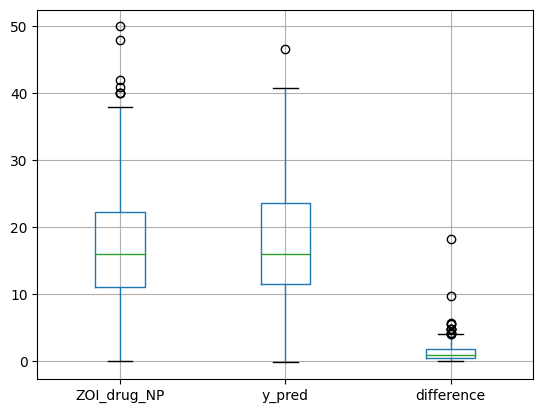

In [31]:
train_an.boxplot()
plt.show()

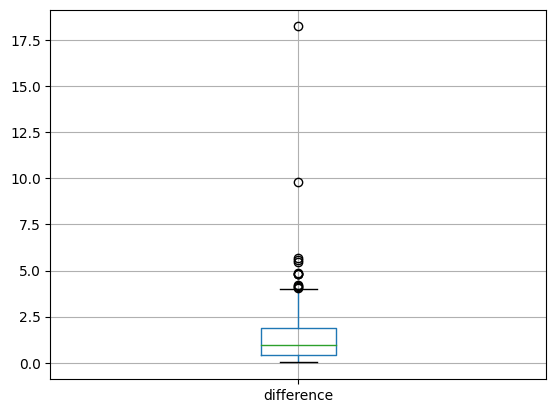

In [32]:
train_an.boxplot('difference')
plt.show()

In [33]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[X])

In [34]:
shap_values.shape

(384, 14)

In [35]:
train['ZOI_drug_NP'].mean()

16.903216145833333

In [36]:
explainer.expected_value

16.895188673590354

In [37]:
shap_values[0,:]

array([-1.83324098, -2.13089093, -1.36792103,  1.83177532,  0.45146954,
        0.30557649,  0.14990629, -0.50955916,  0.17037568,  0.36607622,
       -0.11740687,  0.14600812, -0.02380204, -0.0025681 ])

In [38]:
train[X].iloc[0,:]

NP size_min                      4.000000
NP size_max                     10.000000
NP size_avg                      8.000000
ZOI_drug                        17.000000
NumHDonors                       1.000000
NumHAcceptors                    6.000000
MaxAbsPartialCharge              0.486917
MinAbsPartialCharge              0.340723
MinPartialCharge                -0.486917
avg_Incub_period, h             84.000000
growth_temp, C                  37.000000
shape_nanorods_and_triangles     0.000000
gram_p                           0.000000
biosafety_level                  2.000000
Name: 0, dtype: float64

In [39]:
print('train_an')
print(train_an.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values[0,:], train[X].iloc[0,:])

train_an
ZOI_drug_NP    16.000000
y_pred         14.330987
difference      1.669013
Name: 0, dtype: float64


In [40]:
print(train_an.iloc[1,:])
shap.force_plot(explainer.expected_value, shap_values[1,:], train[X].iloc[1,:])

ZOI_drug_NP    0.600000
y_pred         0.396815
difference     0.203185
Name: 1, dtype: float64


In [41]:
print(train_an.iloc[2,:])
shap.force_plot(explainer.expected_value, shap_values[2,:], train[X].iloc[2,:])

ZOI_drug_NP     8.000000
y_pred         10.396452
difference      2.396452
Name: 2, dtype: float64


In [42]:
print(train_an.iloc[51,:])

shap.force_plot(explainer.expected_value, shap_values[51,:], train[X].iloc[51,:])

ZOI_drug_NP    50.000000
y_pred         31.757731
difference     18.242269
Name: 51, dtype: float64


In [43]:
print(train_an.iloc[229,:])
shap.force_plot(explainer.expected_value, shap_values[229,:], train[X].iloc[229,:])

ZOI_drug_NP    16.000000
y_pred         11.162326
difference      4.837674
Name: 229, dtype: float64


In [44]:
print(train_an.iloc[249,:])
shap.force_plot(explainer.expected_value, shap_values[249,:], train[X].iloc[249,:])

ZOI_drug_NP     7.000000
y_pred         11.162326
difference      4.162326
Name: 249, dtype: float64


In [45]:
print(train_an.iloc[186,:])
shap.force_plot(explainer.expected_value, shap_values[186,:], train[X].iloc[186,:])

ZOI_drug_NP    17.000000
y_pred         12.197231
difference      4.802769
Name: 186, dtype: float64


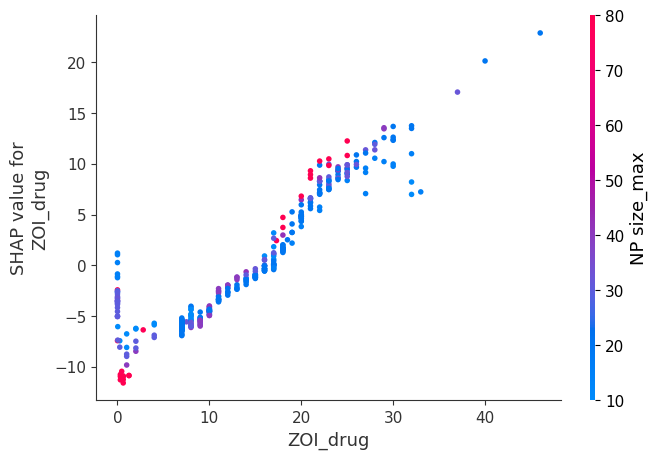

In [46]:
shap.dependence_plot("ZOI_drug", shap_values, train[X])

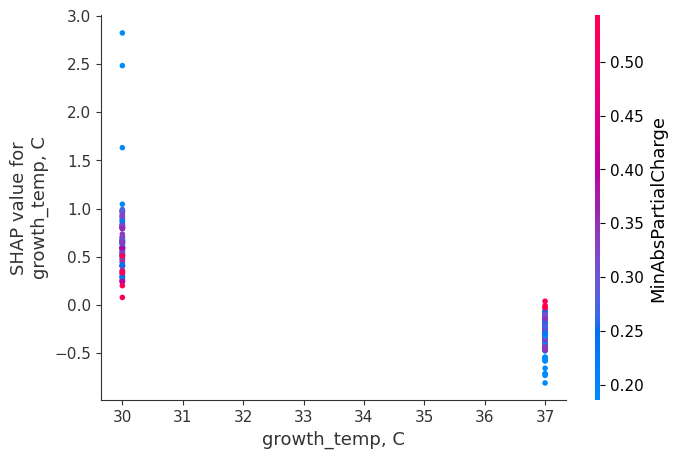

In [47]:
shap.dependence_plot("growth_temp, C", shap_values, train[X])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


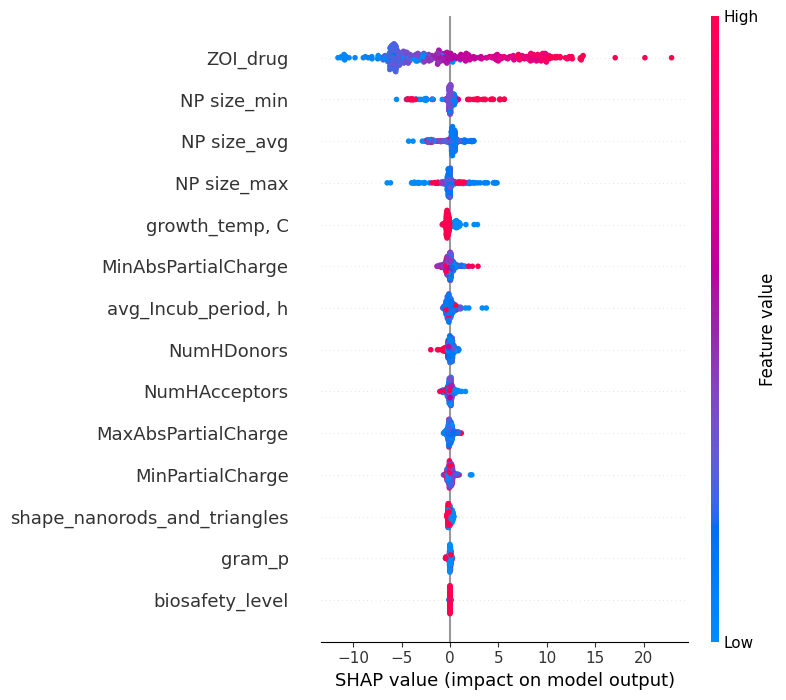

In [48]:
shap.summary_plot(shap_values, train[X])

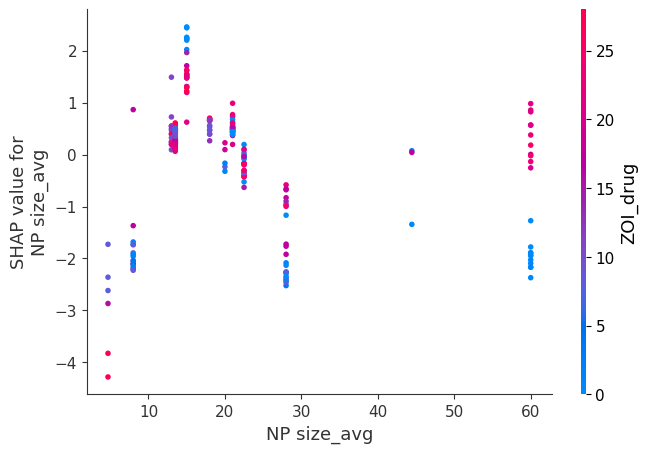

In [49]:
shap.dependence_plot("NP size_avg", shap_values, train[X])

In [50]:
gr = model.get_feature_importance(prettified=True)
gr

,Feature Id,Importances
0,ZOI_drug,51.053805
1,NP size_min,12.174807
2,NP size_max,10.744123
3,NP size_avg,8.510996
4,MinAbsPartialCharge,3.254374
5,"avg_Incub_period, h",2.833853
6,MinPartialCharge,2.226143
7,NumHAcceptors,2.096870
8,NumHDonors,2.089379
9,MaxAbsPartialCharge,1.866726


In [51]:
dummy_regr1 = DummyRegressor(strategy="mean")
dummy_regr1.fit(train[X],train[y])
dummy_regr1 = dummy_regr1.predict(test[X])
sm_for_d = np.sqrt(mean_squared_error(dummy_regr1,test[y]))
sm_for_d

10.336453865675864

у нас rmse ниже чем заполнение средним , значит модель работает , остальное что увидел напишу в выводе